# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

### 1. Creating dictionary of liquor types and category names

liquor_list = ['vodka', 'schnapps', 'whiskey', 'rum', 'scotch', 'gin', 'liqueurs', \
               'brandies', 'tequila', 'beer', 'other']
liquor_list = [i.upper() for  i in liquor_list]
liquor_dict = {key: [] for key in liquor_list}

def liquor_category(adf, alist):
    for x in alist:
        for i in adf:
            if type(i) == float:
                pass
            else:
                if x in i:
                    liquor_dict.update({x:i})
                else:
                    pass

liquor_category(iowa2['category_name'], liquor_list)
liquor_dict

### 2. Converting zip code to int

iowa['zip_code'].fillna(value=np.nan, inplace=True)

null_zip_code = 0
null_zip_list = iowa['zip_code'].isnull()
len(null_zip_list)

In [97]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
%matplotlib inline 

from sklearn import datasets
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import r2_score

In [98]:
## Load the data into a DataFrame
csv_filepath = '/Users/kristensu/dropbox/GA-DSI/DSI-copy/projects/projects-weekly/project-03/Iowa_Liquor_sales_sample_10pct.csv'
iowa = pd.read_csv(csv_filepath)

In [99]:
iowa.head(3)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/4/15,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,3/2/16,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,2/11/16,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34


In [100]:
print iowa.columns
print iowa.shape

Index([u'Date', u'Store Number', u'City', u'Zip Code', u'County Number',
       u'County', u'Category', u'Category Name', u'Vendor Number',
       u'Item Number', u'Item Description', u'Bottle Volume (ml)',
       u'State Bottle Cost', u'State Bottle Retail', u'Bottles Sold',
       u'Sale (Dollars)', u'Volume Sold (Liters)', u'Volume Sold (Gallons)'],
      dtype='object')
(270955, 18)


# Clean Data

### Drop duplicate columns

In [101]:
#Drop cols that contain same info as another col
iowa.drop(['County Number', 'Category', 'Item Number', 'Volume Sold (Gallons)'], axis=1, inplace=True)

### Clean column names

In [102]:
# Clean column name 1: Rename columns
iowa.rename(columns={'Bottle Volume (ml)':'Bottle Volume', 'Sale (Dollars)':'Sales', \
               'Volume Sold (Liters)':'Volume Sold'}, inplace=True)

# Clean column names 2: Change all column names to lowercase letters
iowa.rename(columns=lambda x: x.lower(), inplace=True)

# Clean column names 3: Replace ' ' with '_'
iowa.rename(columns=lambda x: x.replace(" ","_"), inplace=True)

In [103]:
iowa.isnull().sum()

date                      0
store_number              0
city                      0
zip_code                  0
county                 1077
category_name           632
vendor_number             0
item_description          0
bottle_volume             0
state_bottle_cost         0
state_bottle_retail       0
bottles_sold              0
sales                     0
volume_sold               0
dtype: int64


### Clean values in columns with currency and date

### *Clean zip codes later on

In [104]:
# Convert columns with dollar amounts from object to numeric float
currency = ['sales', 'state_bottle_cost', 'state_bottle_retail']
iowa[currency] = iowa[currency].apply(lambda x: x.str.replace('$',''))
iowa[currency] = iowa[currency].apply(lambda x: x.str.replace(',',''))
iowa[currency] = iowa[currency].apply(lambda x: pd.to_numeric(x))

# Convert date from object to datetime
iowa['date'] = pd.to_datetime(iowa['date'])

In [105]:
iowa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270955 entries, 0 to 270954
Data columns (total 14 columns):
date                   270955 non-null datetime64[ns]
store_number           270955 non-null int64
city                   270955 non-null object
zip_code               270955 non-null object
county                 269878 non-null object
category_name          270323 non-null object
vendor_number          270955 non-null int64
item_description       270955 non-null object
bottle_volume          270955 non-null int64
state_bottle_cost      270955 non-null float64
state_bottle_retail    270955 non-null float64
bottles_sold           270955 non-null int64
sales                  270955 non-null float64
volume_sold            270955 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(4), object(5)
memory usage: 28.9+ MB


### Check for and replace NaNs

In [106]:
iowa.isnull().sum()

date                      0
store_number              0
city                      0
zip_code                  0
county                 1077
category_name           632
vendor_number             0
item_description          0
bottle_volume             0
state_bottle_cost         0
state_bottle_retail       0
bottles_sold              0
sales                     0
volume_sold               0
dtype: int64

### Remove Duplicate County Names & Fill in Missing Counties

In [233]:
# Match missing County with City
df_county = pd.pivot_table(iowa, index=['city', 'county'], values=['sales'], aggfunc=sum)
df_county.drop('sales', axis=1, inplace=True)
df_county.reset_index(inplace=True)
df_county.head()

,city,county
0,ACKLEY,Hardin
1,ACKLEY,Webster
2,ADAIR,Adair
3,ADEL,Dallas
4,AFTON,Union


In [234]:
print df_county['city'].duplicated().sum()
a = df_county[df_county['city'].duplicated() == True].index.tolist()
df_county['city'].loc[a]

11


1               ACKLEY
33          BETTENDORF
66               CLIVE
74             CORNING
135         FORT DODGE
260             NEWTON
264      NORTH LIBERTY
277          OSKALOOSA
289              PERRY
337       STATE CENTER
380    WEST DES MOINES
Name: city, dtype: object

In [235]:
b = [i+1 for i in a]
c = [i-1 for i in a]
d = a + b + c
e = sorted(d)

In [236]:
df_county.loc[e, :]
county_dict = {'bettendorf':'scott', 'corning':'adams', 'fort dodge': 'webster','newton':'jasper', \
               'north libery':'johnson', 'OSKALOOSA': 'mahaska', 'PERRY':'dallas', 'STATE CENTER': 'marshall'}
# Did not use drop_duplicates() because I did not want to automatically drop the second duplicate
# So I checked the counties of duplicate cities and dropped incorrect city-county mappings
# It also turns out some towns (Ackley, Clive, and West Des Moines are located in multiple counties)
# Remove from iowa dataframe: index [32, 74, 134, 260, 263, 276, 288, 336]

In [237]:
# Remove from iowa dataframe: index [32, 74, 134, 260, 263, 276, 288, 336]
df_county.drop([32, 74, 134, 260, 263, 276, 288, 336], inplace=True)

# Rename Ackley, Clive, and West Des Moines to account for parts of town in different counties
df_county.set_value([1,66,380], 'city', ['ACKLEY_WEBSTER', 'CLIVE_POLK', 'WEST_DES_MOINES_POLK'])

,city,county
0,ACKLEY,Hardin
1,ACKLEY_WEBSTER,Webster
2,ADAIR,Adair
3,ADEL,Dallas
4,AFTON,Union
5,AKRON,Plymouth
6,ALBIA,Monroe
7,ALDEN,Hardin
8,ALGONA,Kossuth
9,ALLISON,Butler


In [238]:
# Merge df_county into original iowa df
# Note: Original "county" renamed "county_x" and new "county_y" col created
iowa2 = pd.merge(iowa,df_county, on = "city", how = "left")
iowa2.head()

,date,store_number,city,zip_code,county_x,category_name,vendor_number,item_description,bottle_volume,state_bottle_cost,state_bottle_retail,bottles_sold,sales,volume_sold,county_y
0,2015-11-04,3717,SUMNER,50674,Bremer,APRICOT BRANDIES,55,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,Bremer
1,2016-03-02,2614,DAVENPORT,52807,Scott,BLENDED WHISKIES,395,Tin Cup,750,13.75,20.63,2,41.26,1.5,Scott
2,2016-02-11,2106,CEDAR FALLS,50613,Black Hawk,STRAIGHT BOURBON WHISKIES,65,Jim Beam,1000,12.59,18.89,24,453.36,24.0,Black Hawk
3,2016-02-03,2501,AMES,50010,Story,AMERICAN COCKTAILS,395,1800 Ultimate Margarita,1750,9.50,14.25,6,85.50,10.5,Story
4,2015-08-18,3654,BELMOND,50421,Wright,VODKA 80 PROOF,297,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.0,Wright


In [246]:
# Fill missing county names in "county_x" with county names from "county_y"
iowa2["county_x"].fillna(iowa2["county_y"], inplace=True)
iowa2.isnull().sum()

date                     0
store_number             0
city                     0
zip_code                 0
county_x                12
category_name          632
vendor_number            0
item_description         0
bottle_volume            0
state_bottle_cost        0
state_bottle_retail      0
bottles_sold             0
sales                    0
volume_sold              0
county_y                12
dtype: int64

In [252]:
# Check for remaining missing counties
iowa[iowa2["county_x"].isnull()]['city'].unique()

array(['TABOR', 'SEYMOUR', 'RUNNELLS'], dtype=object)

In [257]:
# Fill in missing counties by mapping to city
def county_name(city):
    if city == "TABOR":
        return "Fremont"
    elif city == "SEYMOUR":
        return "Wayne"
    elif city == "RUNNELLS":
        return "Polk"
    else:
        pass

iowa2["county_y"] = iowa2["city"].apply(county_name)
iowa2['county_x'].fillna(iowa2['county_y'], inplace=True)

In [270]:
iowa2.isnull().sum()

date                        0
store_number                0
city                        0
zip_code                    0
county_x                    0
category_name             632
vendor_number               0
item_description            0
bottle_volume               0
state_bottle_cost           0
state_bottle_retail         0
bottles_sold                0
sales                       0
volume_sold                 0
county_y               270943
dtype: int64

### Fill in Missing Category Names

In [260]:
iowa2.head(2)

,date,store_number,city,zip_code,county_x,category_name,vendor_number,item_description,bottle_volume,state_bottle_cost,state_bottle_retail,bottles_sold,sales,volume_sold,county_y
0,2015-11-04,3717,SUMNER,50674,Bremer,APRICOT BRANDIES,55,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,None
1,2016-03-02,2614,DAVENPORT,52807,Scott,BLENDED WHISKIES,395,Tin Cup,750,13.75,20.63,2,41.26,1.5,None


In [265]:
# repeat same process to impute missing category values from item
df_category_name = pd.pivot_table(iowa2,index = ["item_description","category_name"], \
                                  values = ["sales"], aggfunc = sum)
df_category_name.reset_index(inplace = True)
df_category_name.drop("sales", axis=1, inplace=True)


In [266]:
df_category_name.isnull().sum()

item_description    0
category_name       0
dtype: int64

In [269]:
df_category_name['category_name'].unique()

array(['BARBADOS RUM', 'STRAIGHT BOURBON WHISKIES', 'TEQUILA',
       'AMERICAN COCKTAILS', 'CREAM LIQUEURS', 'IRISH WHISKIES',
       'DECANTERS & SPECIALTY PACKAGES', 'BLENDED WHISKIES',
       'VODKA FLAVORED', 'VODKA 80 PROOF', 'APPLE SCHNAPPS',
       'MISCELLANEOUS SCHNAPPS', 'SINGLE MALT SCOTCH',
       'MISC. IMPORTED CORDIALS & LIQUEURS', 'IMPORTED VODKA - MISC',
       'IMPORTED VODKA', 'SPICED RUM', 'FLAVORED RUM', 'CINNAMON SCHNAPPS',
       'CANADIAN WHISKIES', 'DISTILLED SPIRITS SPECIALTY',
       'AMERICAN AMARETTO', 'IMPORTED AMARETTO',
       'MISC. AMERICAN CORDIALS & LIQUEURS', 'JAMAICA RUM',
       'SCOTCH WHISKIES', 'MISCELLANEOUS  BRANDIES',
       'IMPORTED GRAPE BRANDIES', 'ANISETTE', 'APRICOT BRANDIES',
       'BLACKBERRY BRANDIES', 'GREEN CREME DE MENTHE',
       'PEPPERMINT SCHNAPPS', 'CREME DE ALMOND', 'DARK CREME DE CACAO',
       'WHITE CREME DE CACAO', 'AMERICAN DRY GINS',
       'BUTTERSCOTCH SCHNAPPS', 'PEACH SCHNAPPS', 'RASPBERRY SCHNAPPS',
       'AME

In [ ]:
df_category_name.drop_duplicates(['item'], inplace=True)
df_category_name.drop("bottles sold", axis=1, inplace = True)
df = pd.merge(df,item_category, on = "item", how = "left")
df['category_x'].fillna(df['category_y'], inplace=True)
np.sum(df.isnull())

In [94]:
iowa['zip_code'].fillna(value=np.nan, inplace=True)

In [93]:
null_zip_code = 0
null_zip_list = iowa['zip_code'].isnull()
len(null_zip_list)

270955

In [95]:
iowa.isnull().sum()

date                      0
store_number              0
city                      0
zip_code                217
county                 1077
category_name           632
vendor_number             0
item_description          0
bottle_volume             0
state_bottle_cost         0
state_bottle_retail       0
bottles_sold              0
sales                     0
volume_sold               0
dtype: int64

### Drop NaNs

In [ ]:
#Assuming that none of the nans in the columns overlap, the percentage of nans in the iowa dataframe
total_na = sum(iowa.isnull().sum())
ratio_na = float(total_na)/(len(iowa.index.values))
print 'Percent of nans before drop: ', str(round(ratio_na*100,2)), '%' 

#Drop all nans as percentage of nans is small enough to be negligible
iowa.dropna(inplace=True)
print 'Total nans:'
print iowa.isnull().sum()
print 'Percent of nans after drop: ', str(round((float(sum(iowa.isnull().sum())*100)),2)), '%'

In [ ]:
###################################################

In [113]:
iowa_df = pd.pivot_table(iowa, index=['store_number','county', 'item_description'], columns=None, values=['sales', 'volume_sold'], aggfunc=np.sum)

In [114]:
iowa_df

sales  \
store_number county     item_description                                  
2106         Black Hawk 1800 Reposado Tequila                    834.84   
                        360 Double Chocolate Vodka                42.00   
                        Absolut Apeach                           620.64   
                        Absolut Citron (lemon Vodka)            1223.40   
                        Absolut Hibiskus                         206.88   
                        Absolut Mango Vodka                      413.76   
                        Absolut Pears                            413.76   
                        Absolut Peppar                           827.52   
                        Absolut Swedish Vodka 80 Prf            5478.48   
                        Admiral Nelson Coconut Rum               104.04   
                        Admiral Nelson Spiced Rum                312.12   
                        Ancient Age Bourbon                       27.72   
                        Arrow Blackberry Flav Brandy              96.84   
                        Arrow Creme De Menthe Green               81.00   
                        Arrow Mcdale's Butterscotch Schnapps      78.12   
                        Arrow Peach Schnapps                     630.00   
                        Arrow Peppermint Schnapps                130.68   
                        Arrow Raspberry Schnapps                 180.00   
                        Auchentoshan American Oak                 94.47   
                        Avion Reposado                            39.74   
                        Bacardi 151 Prf                          486.00   
                        Bacardi 151 Proof Rum                    243.00   
                        Bacardi 8 w/2 Glasses                     94.50   
                        Bacardi Black Razz                       342.00   
                        Bacardi Dragon Berry                     684.00   
                        Bacardi Limon                            855.00   
                        Bacardi O                                513.00   
                        Bacardi Superior Rum                    1827.36   
                        Bailey's Original Irish Cream            931.68   
                        Barton Gin                               423.36   
...                                                                 ...   
9002         Scott      Barrel River Rose Gin                    327.36   
                        Big Peach Liqueur                       2455.20   
                        Chick's Vodka                           1090.08   
                        Cody Road Bourbon                       3796.32   
                        Cody Road Rye                           5004.24   
                        Cody Road Single Barrel                 1132.80   
                        Iowa Coffee Company Liqueur              982.08   
                        Iowish Cream Liqueur                    6226.08   
                        Iowish Whiskey                           862.80   
                        Pride of the Wapsi                      1636.80   
                        Queen Bee Honey Whiskey                 8184.00   
                        River Baron Artisian Spirit              757.08   
                        River Pilot Vodka                       3228.36   
                        River Rose Gin                          1601.16   
                        Stone Fence Apple Cider Whiskey         1636.80   
9010         Warren     Bella Limoncello                         709.92   
                        Hot Lil' Hooch Cherry Cinnamon Whiskey   717.84   
                        Itty Bitty Juggs Sample Pack             324.00   
                        Juggs Blueberry Bazoombas                478.56   
                        Juggs Cherry Cha-Cha's                   717.84   
                        Two Jay's Country Style Blended Why.    1684.08   
                

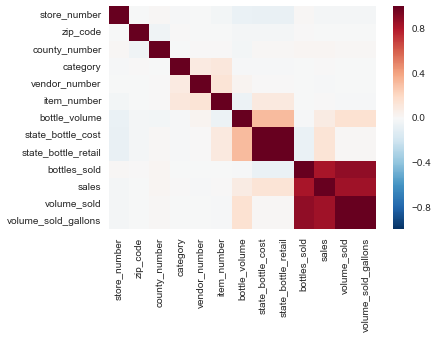

In [119]:
sns.heatmap(iowa.corr())

In [120]:
iowa_target = pd.DataFrame(iowa['sales'])

In [142]:
iowa_cols = []
for x in iowa:
    if iowa[x].dtype == float:
        iowa_cols.append(x)
    elif iowa[x].dtype == int:
        iowa_cols.append(x)
    else:
        pass

In [143]:
iowa_cols

['store_number',
 'zip_code',
 'county_number',
 'category',
 'vendor_number',
 'item_number',
 'bottle_volume',
 'state_bottle_cost',
 'state_bottle_retail',
 'bottles_sold',
 'sales',
 'volume_sold',
 'volume_sold_gallons']

In [145]:
iowa_df = iowa[iowa_cols]

In [147]:
iowa_df.drop('sales', axis=1, inplace=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [158]:
X = iowa_df
y =  iowa_target

lr = linear_model.LinearRegression()
lr_model = lr.fit(X,y)

y_pred = lr_model.predict(iowa_df)
y_pred_df =  pd.DataFrame(y_pred)

ValueError: Argument dimensions are incompatible

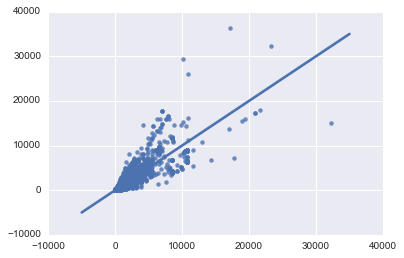

In [157]:
ax = sns.regplot(y_pred, y)
ax.figure.set_figheight(6)
ax.figure.set_figwidth(14)

ax.set_ylabel('Actual Values')
ax.set_xlabel('Predicted Values')
ax.set_title('Predicted vs. Actual Values');

In [153]:
lr_r2 =  r2_score(y_true=y, y_pred=y_pred)
lr_r2

0.77017501939506761

In [154]:
len(lr_model.coef_)

1

In [155]:
lr_model.coef_

array([[ -2.17204471e-03,  -1.82825396e-04,   5.84292343e-02,
          9.54960175e-05,  -1.90054507e-02,  -7.69417890e-05,
         -3.90405924e-02,   4.43882807e+01,  -2.33908950e+01,
          6.04164932e+00,   2.59660979e+02,  -9.56992665e+02]])

In [75]:
#df.groupby ( ‘key’ ) [ ‘ what to aggregate’ ].how_to_aggregate

store_sales = iowa.groupby(['store_number'])['sales'a].sum().to_frame()

In [76]:
store_sales

,sales
store_number,
2106,176517.45
2113,11376.12
2130,139440.02
2152,8625.74
2178,29912.68
2190,153492.12
2191,172431.69
2200,26986.42
2205,24623.01


In [69]:
iowa['bottle_volume'].unique()

array([ 750, 1000, 1750,  200,  300,  500,  375, 3000, 2400,  600,  100,
       1200,  800, 4800,  150, 2250,  400, 3600,   50,  850,  950,  603,
       2550, 1125, 6000, 4500,  900,  250, 1500])

In [ ]:
{'vodka': }
#vodka
#schnapps
#whiskey
#rum
#scotch
#gin
#liqueurs
#brandies
#tequila
#beer
#other


In [63]:
iowa['category_name'].nunique()

71

In [23]:
iowa['date'].dtypes

dtype('O')

In [24]:
## Transform the dates if needed, e.g.
iowa['date'] = iowa['date'].str.replace('/','-') 
iowa['date'] = pd.to_datetime(iowa['date'], format= '%m-%d-%Y')

In [29]:
# Check for null or other weird values
iowa.isnull().sum()

date                      0
store_number              0
city                      0
zip_code                  0
county_number          1077
county                 1077
category                 68
category_name           632
vendor_number             0
item_number               0
item_description          0
bottle_volume             0
state_bottle_cost         0
state_bottle_retail       0
bottles_sold              0
sales                     0
volume_sold               0
volume_sold_gallons       0
dtype: int64

In [ ]:
iowa.dtypes

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
len(iowa['County'].value_counts())

In [ ]:
iowa_county = pd.pivot_table(iowa, index=iowa['County'], values=['Sale (Dollars)'])
iowa_county.head()

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [ ]:
from sklearn import linear_model


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.